<a href="https://colab.research.google.com/github/nathanr8/FaceDetection/blob/main/FaceDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q kaggle
import tensorflow as tf

In [68]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import time
import random
from google.colab import files
from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import matplotlib.cm as cm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.regularizers  import L2, L1
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature
from google.colab import drive

In [70]:
train_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/train"
validation_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/test"
CLASS_NAMES = ["angry", "happy", "sad"]

CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 256,
    "LEARNING_RATE": 0.001,
    "N_EPOCHS": 2,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 100,
    "N_DENSE_2": 10,
    "NUM_CLASSES": 3,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
    "CLASS_NAMES": ["angry", "happy", "sad"],
}

In [71]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [72]:
! chmod 600 /root/.kaggle/kaggle.json

In [73]:
!kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

human-emotions-datasethes.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip "/content/human-emotions-datasethes.zip" -d "/content/dataset/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/EmotionsDataset/data/nothing/720.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/721.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/722.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/723.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/724.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/725.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/726.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/727.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/728.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/729.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/73.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/730.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/731.jpg  
  inflating: /content/dataset/EmotionsDataset/data/no

In [74]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=99,
)

Found 6799 files belonging to 3 classes.


In [75]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 2278 files belonging to 3 classes.


In [ ]:
for i in val_dataset.take(1):
  print(i)

(<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[ 20.        ,  20.        ,  20.        ],
         [ 19.1875    ,  19.1875    ,  19.1875    ],
         [ 19.        ,  19.        ,  19.        ],
         ...,
         [ 29.125     ,  29.125     ,  29.125     ],
         [ 25.        ,  25.        ,  25.        ],
         [ 25.        ,  25.        ,  25.        ]],

        [[ 20.        ,  20.        ,  20.        ],
         [ 19.847656  ,  19.847656  ,  19.847656  ],
         [ 19.8125    ,  19.8125    ,  19.8125    ],
         ...,
         [ 28.820312  ,  28.820312  ,  28.820312  ],
         [ 25.660156  ,  25.660156  ,  25.660156  ],
         [ 25.        ,  25.        ,  25.        ]],

        [[ 20.6875    ,  20.6875    ,  20.6875    ],
         [ 21.246094  ,  21.246094  ,  21.246094  ],
         [ 21.847656  ,  21.847656  ,  21.847656  ],
         ...,
         [ 25.3125    ,  25.3125    ,  25.3125    ],
         [ 22.375     ,  22.375     ,  22.375 

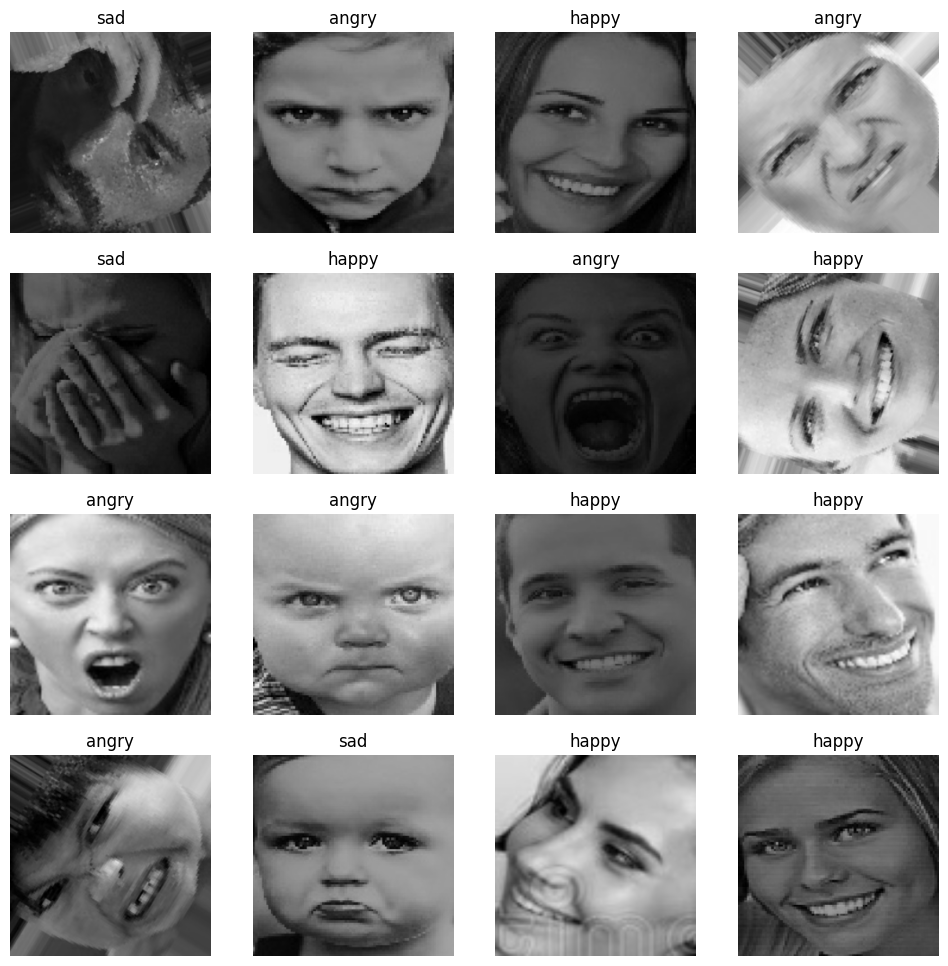

In [76]:
plt.figure(figsize = (12,12))

for images, labels in train_dataset.take(1):
  for i in range(16):
     ax = plt.subplot(4,4, i+1)
     plt.imshow(images[i]/255.)
     plt.title(CLASS_NAMES[tf.argmax(labels[i], axis = 0).numpy()])
     plt.axis("off")

In [77]:
training_dataset = {
    train_dataset
    .prefetch(tf.data.AUTOTUNE)
}

In [78]:
validation_dataset = {
    train_dataset
    .prefetch(tf.data.AUTOTUNE)
}

In [79]:
resize_rescale_layers = tf.keras.Sequential([
    Resizing(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    Rescaling(1./255)
])

In [80]:
lenet_model = tf.keras.Sequential(
    [
    InputLayer(input_shape = (None, None, 3), ),

    resize_rescale_layers,

    Conv2D(filters = CONFIGURATION["N_FILTERS"] , kernel_size = CONFIGURATION["KERNEL_SIZE"], strides = CONFIGURATION["N_STRIDES"] , padding='valid',
          activation = 'relu',kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"] ),

    Conv2D(filters = CONFIGURATION["N_FILTERS"]*2 + 4, kernel_size = CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"], padding='valid',
          activation = 'relu', kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),

    Flatten(),

    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"]),

    Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),

    Dense(CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

])

lenet_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 254, 254, 6)       168       
                                                                 
 batch_normalization_8 (Batc  (None, 254, 254, 6)      24        
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 127, 127, 6)      0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 127, 127, 6)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 125, 125, 16)     

In [81]:
loss_function = CategoricalCrossentropy(from_logits=False)
metrics = [CategoricalAccuracy(name = "accuracy"), TopKCategoricalAccuracy(k=2, name = "top_k_accuracy")]
lenet_model.compile(
    optimizer = Adam(learning_rate = CONFIGURATION['LEARNING_RATE']),
    loss = loss_function,
    metrics = metrics)



In [82]:
history = lenet_model.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs = CONFIGURATION["N_EPOCHS"],
    verbose = 1,
    )

Epoch 1/2
213/213 [==============================] - 533s 2s/step - loss: 0.9279 - accuracy: 0.5755 - top_k_accuracy: 0.8338 - val_loss: 1.0865 - val_accuracy: 0.4223 - val_top_k_accuracy: 0.7739
Epoch 2/2
213/213 [==============================] - 540s 3s/step - loss: 0.6350 - accuracy: 0.7451 - top_k_accuracy: 0.9210 - val_loss: 1.0216 - val_accuracy: 0.5180 - val_top_k_accuracy: 0.8275


<function matplotlib.pyplot.show(close=None, block=None)>

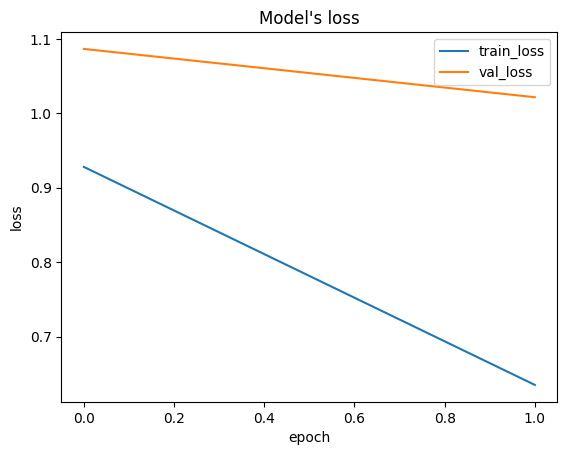

In [83]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model's loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(['train_loss', 'val_loss'])
plt.show

In [84]:
lenet_model.evaluate(val_dataset)

72/72 [==============================] - 47s 639ms/step - loss: 1.0216 - accuracy: 0.5180 - top_k_accuracy: 0.8275


[1.0215555429458618, 0.517998218536377, 0.8274802565574646]

In [85]:
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/happy/110020.jpg")

im = tf.constant(test_image, dtype = tf.float32)

im = tf.expand_dims(im, axis = 0)

print(CLASS_NAMES[tf.argmax(lenet_model(im), axis = -1).numpy()[0]])



happy


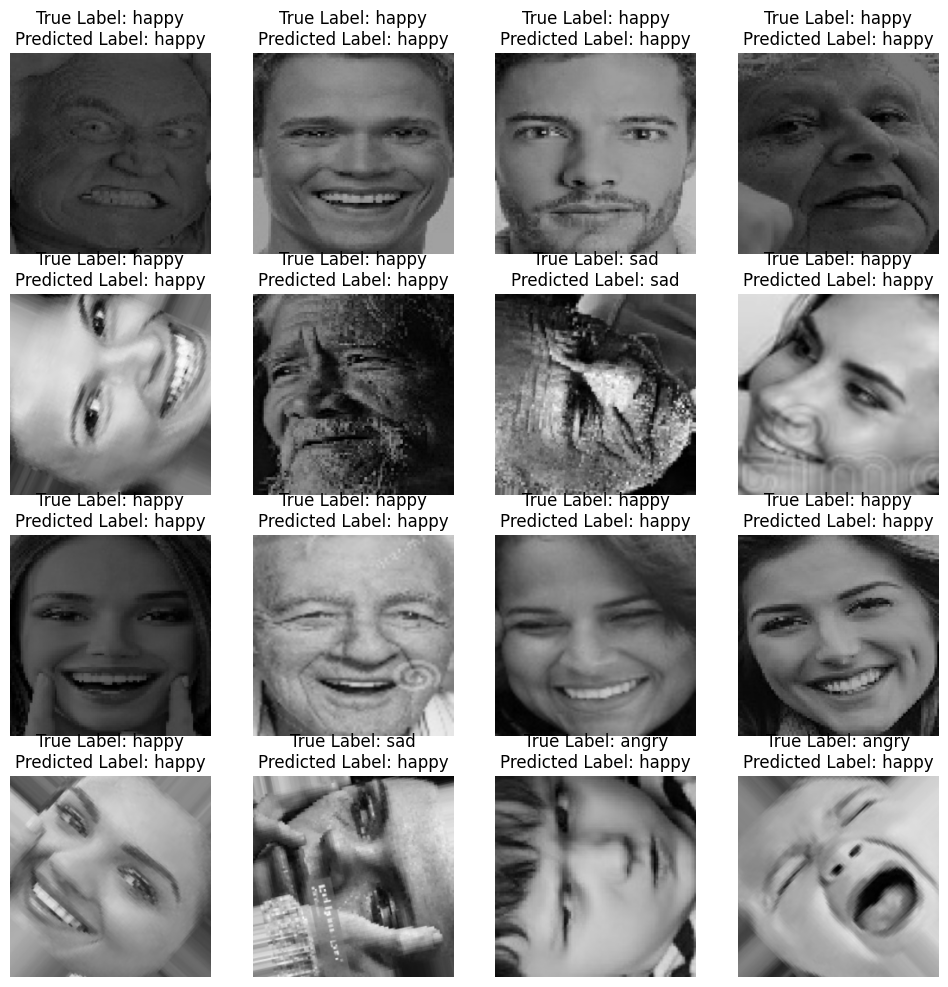

In [86]:
plt.figure(figsize = (12,12))

for images, labels in train_dataset.take(1):
  for i in range(16):
     ax = plt.subplot(4,4, i+1)
     plt.imshow(images[i]/255.)
     plt.title("True Label: " + CLASS_NAMES[tf.argmax(labels[i], axis = 0).numpy()] +
               "\n" + "Predicted Label: " + CLASS_NAMES[tf.argmax(lenet_model(tf.expand_dims(images[i], axis = 0)), axis = -1).numpy()[0]]
               )
     plt.axis("off")

In [90]:
predicted = []
labels = []

for im, label in val_dataset:
  predicted.append(lenet_model(im))
  labels.append(label.numpy())

In [91]:
lab = (np.argmax(labels[:-1], axis = -1).flatten())
pred = (np.argmax(predicted[:-1], axis = -1).flatten())


[[ 53 391  70]
 [  2 977  23]
 [  8 602 146]]


Text(70.72222222222221, 0.5, 'Predicted')

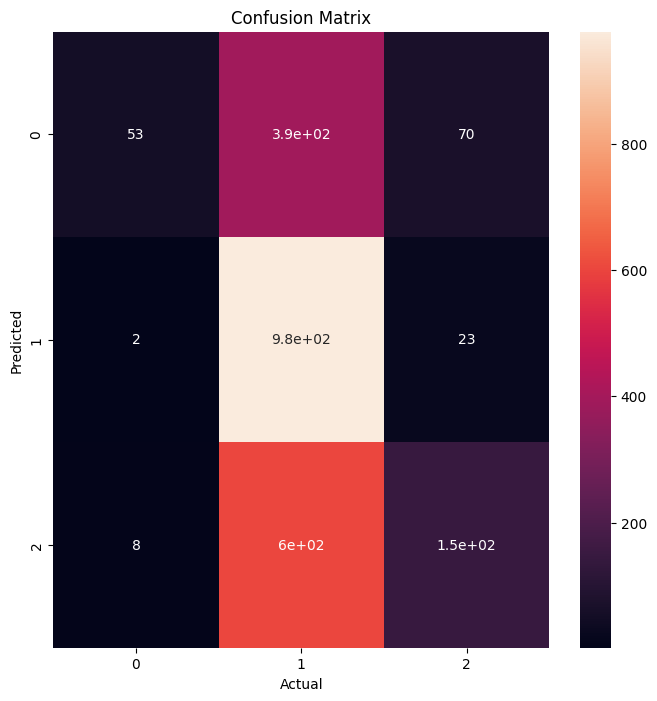

In [94]:
cm = confusion_matrix(lab, pred)
print(cm)
plt.figure(figsize=(8,8))

sns.heatmap(cm, annot=True,)
plt.title('Confusion Matrix'.format(0.5))
plt.xlabel('Actual')
plt.ylabel('Predicted')

Data Augmentation
tf.keras.layers


In [98]:
augment_layers = tf.keras.Sequential([
    RandomRotation(factor = (-0.025, 0.025),),
    RandomFlip(mode='horizontal',),
    RandomContrast(factor=0.1),
])

In [100]:
# training_dataset = (
#     train_dataset
#     .map(augment_layers, num_parallel_calls = tf.data.AUTOTUNE)
#     .prefetch(tf.data.AUTOTUNE)
# )


In [96]:
def augment_layer(image, label):
  return augment_layers(resize_rescale_layers(image), training = True), label